In [19]:
import sys 
sys.path.append('../')

import os
import pandas as pd
from policies.mappo import MAPPO
from environment.optimization_environment import OptimizationEnv
from environment.utils import parse_config
from datetime import datetime
import numpy as np
import seaborn as sns
import os
import neptune
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from other_algorithms.pso import ParticleSwarmOptimizer
import time
from scipy.stats import multivariate_normal
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
def initialize(config_path, mode="train", **kwargs):
    env = OptimizationEnv(config_path)
    agent_policy = MAPPO(config_path)
    if mode == "test" or mode == "benchmark":
        model_path = kwargs.get("model_path", None)
        if model_path is None:
            raise ValueError("Model path must be provided for testing")
        agent_policy.load(model_path)
    return env, agent_policy

def print_items(**kwargs):
    for key, value in kwargs.items():
        print(key, value)
        
def get_action(observation_info, agent_policy, env):
    observation, observation_std = observation_info
    actions = np.zeros((env.n_agents, env.n_dim))
    for dim in range(env.n_dim):
        observation[dim] = observation[dim].astype(np.float32)
        #print(observation[dim])
        observation_std[dim] = observation_std[dim].astype(np.float32)
        action = agent_policy.select_action(observation[dim], observation_std[dim])
        actions[:, dim] = action
    return actions


In [9]:
config_path = '../config/config.json'
model_path = "../models/exploiting_model.pth"
mode = "test"
env, agent_policy = initialize(config_path, mode=mode, model_path=model_path)
config = parse_config(config_path)
agent_policy.set_action_std(config["test_action_std"])

def display_gmm_details(gmm):
    print("Means: ", gmm.means_)
    print("Covariances: ", gmm.covariances_)
    print("Weights: ", gmm.weights_)


Loaded policy from:  ../models/exploiting_model.pth


In [13]:
_ = env.reset()

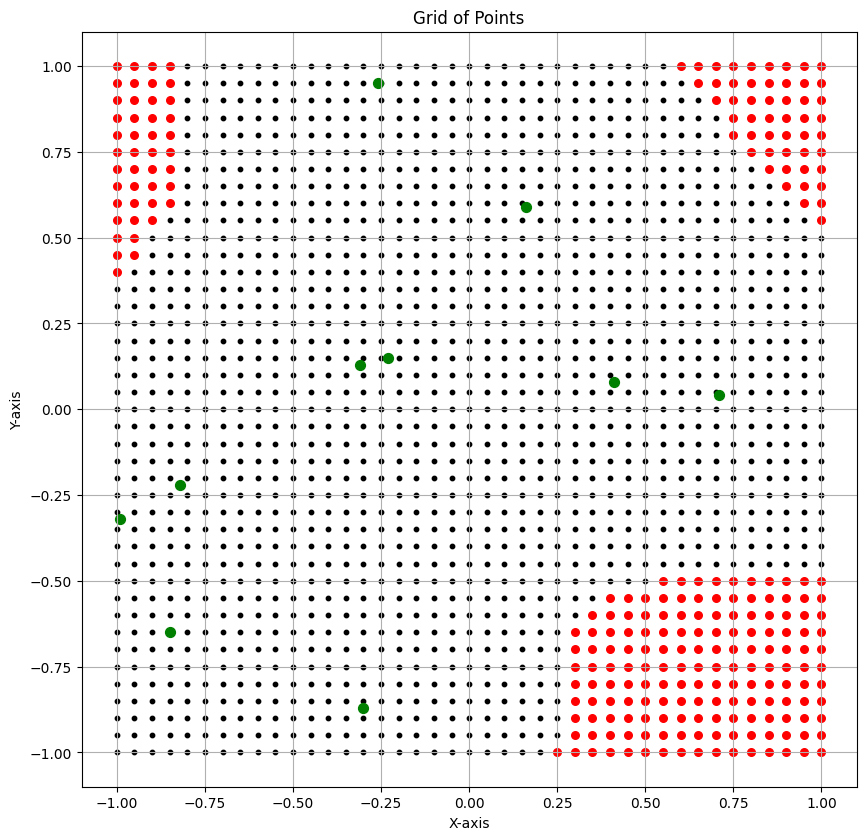

In [14]:
env.surrogate.plot_checkpoints_state()

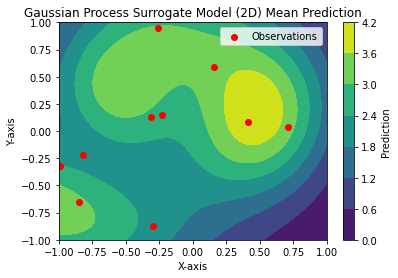

In [15]:
env.surrogate.plot_surrogate()

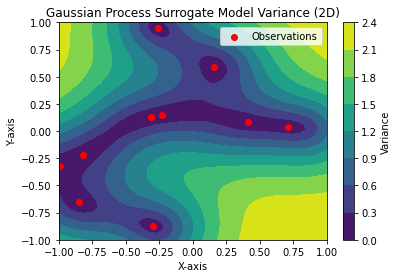

In [16]:
env.surrogate.plot_variance()

In [17]:
def get_informed_action(env):
    # let the action be the distance it takes for the agents to get to the a random point in the high std points
    actions = np.zeros((env.n_agents, env.n_dim))
    high_std_points, high_std_points_std = env._get_unexplored_area()
    taken_points_index = []
    for agents in range(env.n_agents):
        while True:
            index = np.random.randint(0, high_std_points.shape[0])
            if index not in taken_points_index:
                taken_points_index.append(index)
                break
        agent_target = high_std_points[index]
        # get the difference between the agent's current position and the target
        diff = agent_target - env.state[agents][:env.n_dim]
        # add noise to the action
        actions[agents] = diff #+ np.random.normal(-0.1, 0.1, size=env.n_dim)

    return actions
        
        

In [18]:
get_informed_action(env)

array([[ 0.43 , -0.975],
       [-0.345,  0.41 ],
       [-0.705,  0.46 ],
       [ 0.76 , -0.315],
       [ 0.145, -0.37 ],
       [ 0.615,  0.325],
       [ 0.425, -0.04 ],
       [-0.005,  0.51 ],
       [ 0.22 , -0.67 ],
       [ 0.85 , -0.125]])

# VARIANCE DRIVEN EXPLORERS

In [ ]:
observation_info = env.reset()
rewards = []
std_comp = []
hig_std_comp = []
iters = 11
results_buffer = np.zeros((iters, 4))


for i in range(iters):
    print("Iteration: ", i)
    #action =  get_action(observation_info, agent_policy, env)
    action = get_informed_action(env)
    observation_info, reward, done, info = env.step(action)
    rewards.append(np.mean(reward)) 
    env.surrogate.plot_checkpoints_state()

In [ ]:
env.surrogate.plot_checkpoints_state()

In [ ]:
env.render(type="history", file_path="new_history1.gif")

In [ ]:
env.surrogate.plot_surrogate()

In [ ]:
env.surrogate.plot_variance()

# EXPLOITERS

In [ ]:
observation_info = env.reset()
rewards = []
std_comp = []
hig_std_comp = []
iters = 11
results_buffer = np.zeros((iters, 4))


for i in range(iters):
    print("Iteration: ", i)
    action =  get_action(observation_info, agent_policy, env)
    #action = get_informed_action(env)
    observation_info, reward, done, info = env.step(action)
    #env.surrogate.plot_checkpoints_state()

In [ ]:
env.surrogate.plot_checkpoints_state()

In [ ]:
env.surrogate.plot_surrogate()
env.surrogate.plot_variance()

# COMBINING EXPLORERS AND EXPLOITERS

In [ ]:
observation_info = env.reset()
rewards = []
std_comp = []
hig_std_comp = []
iters = 11
results_buffer = np.zeros((iters, 4))


for i in range(iters):
    print("Iteration: ", i)
    exploiters_action =  get_action(observation_info, agent_policy, env)
    explorer_action = get_informed_action(env)
    # split the agents into two groups and let one group exploit and the other explore
    actions = np.zeros((env.n_agents, env.n_dim))
    actions[:env.n_agents//2] = exploiters_action[:env.n_agents//2]
    actions[env.n_agents//2:] = explorer_action[env.n_agents//2:]
    #print(actions)
    observation_info, reward, done, info = env.step(actions)
    env.surrogate.plot_checkpoints_state()
    

In [ ]:
env.surrogate.plot_checkpoints_state()

In [ ]:
env.surrogate.plot_surrogate()
env.surrogate.plot_variance()

In [ ]:
env.surrogate.gp.kernel_.get_params()

In [ ]:
env.render(type="history", file_path="new_history2.gif")

In [ ]:
from src.deephive2 import num_function_evaluation

In [ ]:
observation_info = env.reset()
rewards = []
std_comp = []
hig_std_comp = []
iters = 20
results_buffer = np.zeros((iters, 4))

global_best_value = []
global_best_value.append(env.gbest[-1])
for i in range(iters):
    print("Iteration: ", i)
    exploiters_action =  get_action(observation_info, agent_policy, env)
    explorer_action = get_informed_action(env)
    # split the agents into two groups and let one group exploit and the other explore
    actions = np.zeros((env.n_agents, env.n_dim))
    actions[:env.n_agents//2] = exploiters_action[:env.n_agents//2]
    actions[env.n_agents//2:] = explorer_action[env.n_agents//2:]
    #print(actions)
    observation_info, reward, done, info = env.step(actions)
    global_best_value.append(env.gbest[-1])

    env.surrogate.plot_surrogate()
        #env.surrogate.plot_checkpoints_state()
    # env.surrogate.plot_checkpoints_state()
# save_dir = "results"
# num_function_evaluation(global_best_value, env.n_agents, save_dir, env.objective_function.optimal_value(env.n_dim))

In [ ]:
env.render()

In [ ]:
env.render(type="history", file_path="new_history4.gif")

In [ ]:
from exploration.gp_surrogate import GPSurrogateModule

In [ ]:
bounds = env.bounds
resolution = 0.01

x_min, y_min = bounds[0]
x_max, y_max = bounds[1]


# Create a meshgrid of x and y values within the bounds
x_values = np.arange(x_min, x_max + resolution, resolution)
y_values = np.arange(y_min, y_max + resolution, resolution)
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid to get the individual x and y coordinates
x_coordinates = xx.flatten()
y_coordinates = yy.flatten()

# Create a list of points as (x, y) tuples
points = list(zip(x_coordinates, y_coordinates))

# Convert the list of points to a NumPy array
points_array = np.array(points)

In [ ]:
initial_sample = points_array
initial_values = env.objective_function.evaluate(initial_sample)

In [ ]:
initial_values

In [ ]:
gpp = GPSurrogateModule(initial_samples=initial_sample, initial_values=initial_values, bounds=bounds)